### Model tuning

This notebook is used evaluate the best model for the dataset, perform hyperparameter tuning and cross validation for our chosen model.



In [22]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import PartialDependenceDisplay

In [3]:
data = pd.read_csv('cleaned_df.csv')
# drop unnamed column
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,Name,Age,BMI,Height,Label,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,Huda Mcpherson,36.0,34.174890,163,1,80.0,6.590,1.300427,10.2809,5.065915,15.72187,581.313
1,Cassidy Hayes,75.0,30.480000,192,2,152.0,7.010,2.628283,50.5300,10.060000,11.73000,99.450
2,Arwen Kendall,78.0,25.300000,157,1,60.0,3.508,0.519184,6.6330,10.567295,4.66380,209.749
3,Nathanael Robin,45.0,21.303949,169,2,102.0,13.852,3.485163,7.6476,21.056625,23.03408,552.444
4,Tahmina Carty,34.0,24.242424,177,2,92.0,21.699,4.924226,16.7353,21.823745,12.06534,481.949


In [4]:
#replace label to binary 0 and 1
data = data.replace(1, 0) 
data = data.replace(2, 1)
data.head()

,Name,Age,BMI,Height,Label,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,Huda Mcpherson,36.0,34.174890,163,0,80.0,6.590,1.300427,10.2809,5.065915,15.72187,581.313
1,Cassidy Hayes,75.0,30.480000,192,1,152.0,7.010,2.628283,50.5300,10.060000,11.73000,99.450
2,Arwen Kendall,78.0,25.300000,157,0,60.0,3.508,0.519184,6.6330,10.567295,4.66380,209.749
3,Nathanael Robin,45.0,21.303949,169,1,102.0,13.852,3.485163,7.6476,21.056625,23.03408,552.444
4,Tahmina Carty,34.0,24.242424,177,1,92.0,21.699,4.924226,16.7353,21.823745,12.06534,481.949


In [5]:
X = data.loc[:, ~data.columns.isin(['Name', 'Label'])]
y = data['Label']
X.head()

,Age,BMI,Height,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,36.0,34.174890,163,80.0,6.590,1.300427,10.2809,5.065915,15.72187,581.313
1,75.0,30.480000,192,152.0,7.010,2.628283,50.5300,10.060000,11.73000,99.450
2,78.0,25.300000,157,60.0,3.508,0.519184,6.6330,10.567295,4.66380,209.749
3,45.0,21.303949,169,102.0,13.852,3.485163,7.6476,21.056625,23.03408,552.444
4,34.0,24.242424,177,92.0,21.699,4.924226,16.7353,21.823745,12.06534,481.949


In [6]:
# split and standardise
def split_datasets(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [7]:
def compare_models(models, X_train, y_train, X_test, y_test):
    for model in models:
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        accu = accuracy_score(y_test, y_pred) * 100
        print(
            f"{model[0]}: "
            f"Accuracy: {accu:.2f}"
            )
    return

In [8]:
from sklearn.metrics import mean_squared_error

def split_threshold(model):
    
    np.random.seed(2)
    mse_train = []
    mse_test = []
    threshold_range = np.arange(0.1, 1.0, 0.1)
    
    for a in np.round(threshold_range, 2).tolist():
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=a) 
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse_train.append(mean_squared_error(y_train, model.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, y_pred))
    
    return  mse_train, mse_test

In [9]:
def plot_split_proportion(split, mse):
    plt.figure()
    plt.scatter(split, mse, c='b', label='mse_score', marker='x')
    plt.legend()
    plt.xlabel('Split_Proportion')
    plt.ylabel('Score')
    plt.show()

In [10]:
def average(lst):
    return sum(lst) / len(lst)

In [24]:
np.random.seed(2)

models = [
    ('lgr', make_pipeline(StandardScaler(), LogisticRegression())),
    ('rfc', RandomForestClassifier()),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier())),
    ('dtc', DecisionTreeClassifier()),
    ('abc', AdaBoostClassifier()),
    ('gbc', GradientBoostingClassifier()),
    ('xgb', xgb.XGBClassifier())
    ]

X_train, X_test, y_train, y_test = split_datasets(X, y)
compare_models(models, X_train, y_train, X_test, y_test)

lgr: Accuracy: 70.00
rfc: Accuracy: 63.33
knn: Accuracy: 60.00
dtc: Accuracy: 76.67
abc: Accuracy: 60.00
gbc: Accuracy: 80.00
xgb: Accuracy: 70.00


In [11]:
lgr = LogisticRegression()
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier(max_depth=2)
abc = AdaBoostClassifier()
xgbc = xgb.XGBClassifier(objective="binary:logistic")

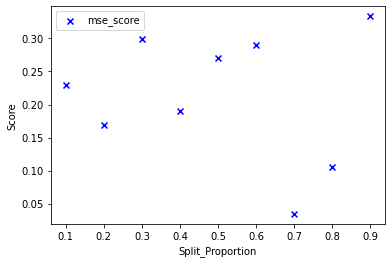

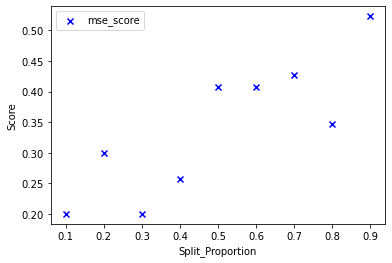

0.34074498776108236

In [67]:
mse_train, mse_test = split_threshold(lgr)
threshold_range = np.arange(0.1, 1.0, 0.1)
split = np.round(threshold_range, 2).tolist()
plot_split_proportion(split, mse_train)
plot_split_proportion(split, mse_test)
average(mse_test)

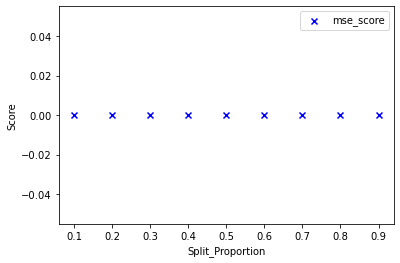

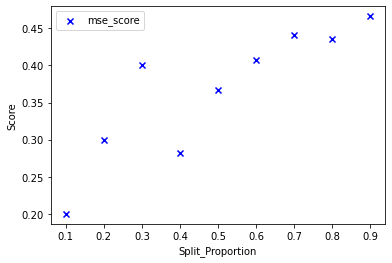

0.3665734310265004

In [68]:
mse_train, mse_test = split_threshold(gbc)
threshold_range = np.arange(0.1, 1.0, 0.1)
split = np.round(threshold_range, 2).tolist()
plot_split_proportion(split, mse_train)
plot_split_proportion(split, mse_test)
average(mse_test)

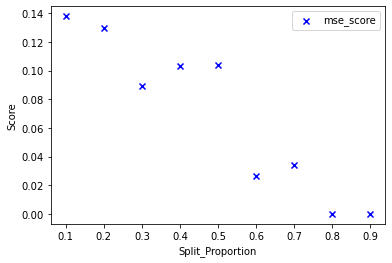

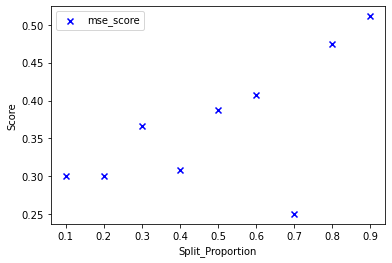

0.36717959423770563

In [69]:
mse_train, mse_test = split_threshold(rfc)
threshold_range = np.arange(0.1, 1.0, 0.1)
split = np.round(threshold_range, 2).tolist()
plot_split_proportion(split, mse_train)
plot_split_proportion(split, mse_test)
average(mse_test)

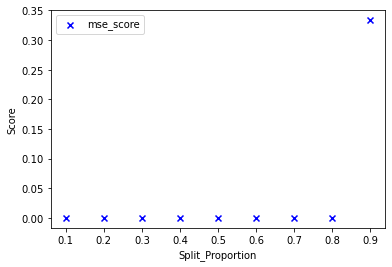

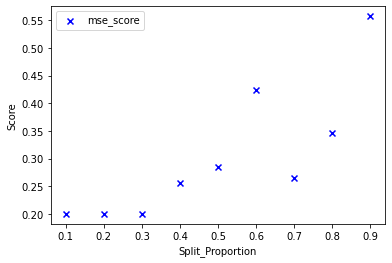

0.30372569622320367

In [71]:
mse_train, mse_test = split_threshold(xgbc)
threshold_range = np.arange(0.1, 1.0, 0.1)
split = np.round(threshold_range, 2).tolist()
plot_split_proportion(split, mse_train)
plot_split_proportion(split, mse_test)
average(mse_test)

In [52]:
np.random.seed(2)

#'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'

models = [
    ('lgr', make_pipeline(StandardScaler(), LogisticRegression(C = 100, penalty = 'l1', solver = 'liblinear'))),
    
    ('rfc', RandomForestClassifier(bootstrap=True,
                                    max_depth=40, 
                                    max_features=2,
                                    min_samples_leaf=4,
                                    min_samples_split=4,
                                    n_estimators=5)),

    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier())),
    
    ('dtc', DecisionTreeClassifier(criterion='log_loss',
                                    splitter='random',
                                    max_depth=8)),
    ('abc', AdaBoostClassifier()),
    ('gbc', GradientBoostingClassifier(learning_rate = 0.7, 
                                        max_depth = 2, 
                                        n_estimators = 40)),
    
    ('xgb', xgb.XGBClassifier(objective="binary:logistic",
                                learning_rate = 0.6,
                                n_estimators = 8,
                                max_depth = 4))
    ]

X_train, X_test, y_train, y_test = split_datasets(X, y)
compare_models(models, X_train, y_train, X_test, y_test)

lgr: Accuracy: 73.33
rfc: Accuracy: 83.33
knn: Accuracy: 60.00
dtc: Accuracy: 80.00
abc: Accuracy: 60.00
gbc: Accuracy: 80.00
xgb: Accuracy: 73.33


### Hyperparameter Tuning

#### 1. Logistic Regression

In [144]:
np.random.seed(2)

lgr = LogisticRegression()
params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

cv = KFold(n_splits=10, random_state=2, shuffle=True)
grid_search = GridSearchCV(lgr, params, scoring='accuracy', n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_result.best_score_ * 100:.2f}%')
print(f'Best Hyperparameters: {grid_result.best_params_}')

/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ceri/miniconda

Best Score: 67.86%
Best Hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

#### 2. Gradient Boost Classifier

In [134]:
np.random.seed(2)
gbc = GradientBoostingClassifier(learning_rate = 0.7, 
                                    max_depth = 2, 
                                    n_estimators = 40)
parameters = {
    "n_estimators":[30,35,40,45],
    "max_depth":[1,2,3,4],
    "learning_rate":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}

grid_search = GridSearchCV(gbc, parameters, cv = 5, verbose=2, n_jobs = -1)
grid_result = grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_result.best_score_ * 100:.2f}%')
print(f'Best Hyperparameters: {grid_result.best_params_}')

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=30; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=35; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=35; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=35; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=35; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=40; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=35; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=1, n

#### 3. XGBoost Classifier

In [136]:
np.random.seed(2)

xgbc = xgb.XGBClassifier(objective="binary:logistic", 
                        learning_rate=0.6,
                        n_estimators=8,
                        max_depth=4)

parameters = {
    'max_depth':[2,3,4,5,6],
    "n_estimators":[1,2,3,4,5,6,7,8,9,10],
    "learning_rate":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
}

grid_search = GridSearchCV(xgbc, parameters, cv = 5, verbose=2, n_jobs = -1)
grid_result = grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_result.best_score_ * 100:.2f}%')
print(f'Best Hyperparameters: {grid_result.best_params_}')

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=1; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=1; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=1; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=1; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=1; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=2; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=2; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=2; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=3; total time=   0.0s
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=2; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=2, n_estimators=3; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=2,

#### 4. Random Forest

In [14]:
np.random.seed(2)

rfc = RandomForestClassifier()
params = {
        'max_depth': [20,30,40],
        'max_features': [2,3],
        'min_samples_leaf': [2,3,4],
        'min_samples_split': [2,3,4],
        'n_estimators': [5,10,15]
        }

cv = KFold(n_splits=10, random_state=2, shuffle=True)
grid_search = GridSearchCV(rfc, params, scoring='accuracy', n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_result.best_score_ * 100:.2f}%')
print(f'Best Hyperparameters: {grid_result.best_params_}')

Best Score: 76.43%
Best Hyperparameters: {'bootstrap': True, 'max_depth': 40, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 5}


#### 5. Decision Tree

In [62]:
np.random.seed(2)

dtc = DecisionTreeClassifier()

params = {'criterion':['gini', 'entropy', 'log_loss'],
        'splitter': ['best', 'random'],
        'max_depth': [2,4,6,8,10,12]
}

cv = KFold(n_splits=10, random_state=2, shuffle=True)
grid_search = GridSearchCV(dtc, params, scoring='accuracy', n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_result.best_score_ * 100:.2f}%')
print(f'Best Hyperparameters: {grid_result.best_params_}')

Best Score: 69.05%
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}


### Feature importance plots

In [138]:
xgbc_tuned = xgb.XGBClassifier(objective="binary:logistic",
                                learning_rate=0.6,
                                n_estimators=8,
                                max_depth=4)
xgbc_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=8, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Text(0, 0.5, 'Feature Importance Score')

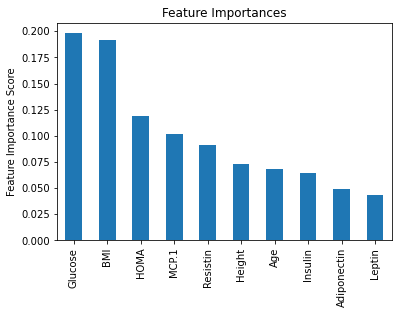

In [139]:
feat_imp = pd.Series(xgbc_tuned.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

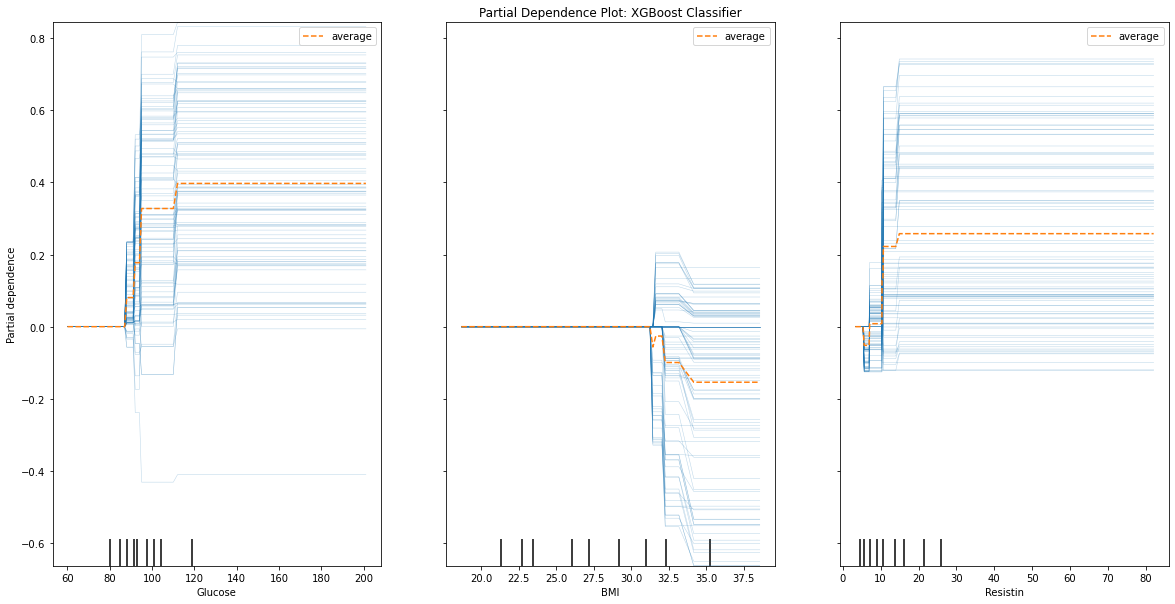

In [142]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Partial Dependence Plot: XGBoost Classifier")
features = ['Glucose', 'BMI', 'Resistin']
fig = PartialDependenceDisplay.from_estimator(xgbc_tuned, X, features, ax=ax, kind='both', centered=True)

In [140]:
gbc_tuned = GradientBoostingClassifier(learning_rate = 0.7, 
                                        max_depth = 2, 
                                        n_estimators = 40)
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.7, max_depth=2, n_estimators=40)

Text(0, 0.5, 'Feature Importance Score')

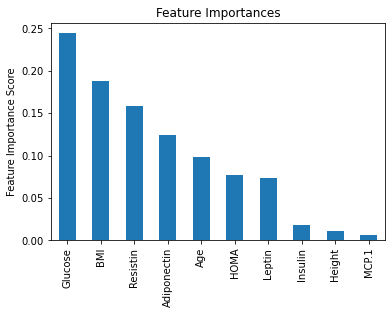

In [141]:
feat_imp = pd.Series(gbc_tuned.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

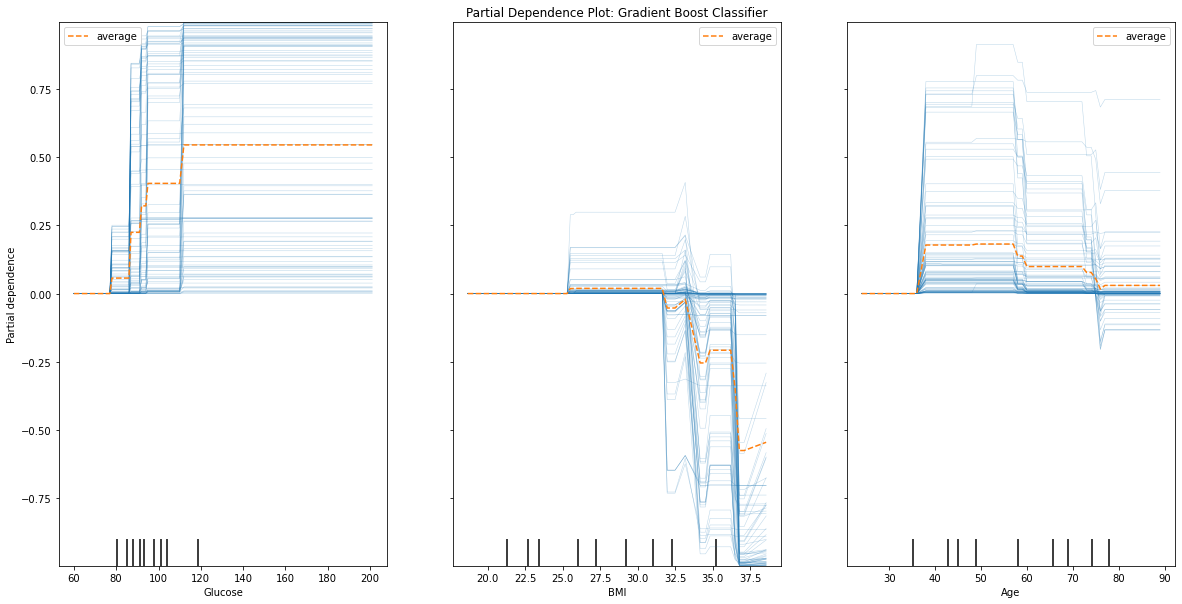

In [143]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Partial Dependence Plot: Gradient Boost Classifier")
features = ['Glucose', 'BMI', 'Age']
fig = PartialDependenceDisplay.from_estimator(gbc_tuned, X, features, ax=ax, kind='both', centered=True)

#### Interpreting PDP and ICE plots:

Dependence = on a patient having cancer

1. Dependence increases with age, beginning just before 40 years and peaking before 60 years. The decrease in dependence as age increases towards 90 years may be attributed to the decrease in samples, some patients being cancer survivors

2. Dependence decreases dramatically with an increase in BMI scores, above 30 is classified as obese. This is interesting as obesity is generally tied to an increase in health problems, and studies have shown that being overweight or having obesity are linked with a higher risk of getting certain types of cancer. 

3. Dependence increases as blood glucose levels increase  

In [146]:
# 'C': 100, 'penalty': 'l1', 'solver': 'liblinear'
# C = 0.01, penalty = 'l2', solver = 'newton-cg'
lgr_tuned = LogisticRegression(C = 100, penalty = 'l1', solver = 'liblinear')
lgr_tuned = lgr_tuned.fit(X_train, y_train)

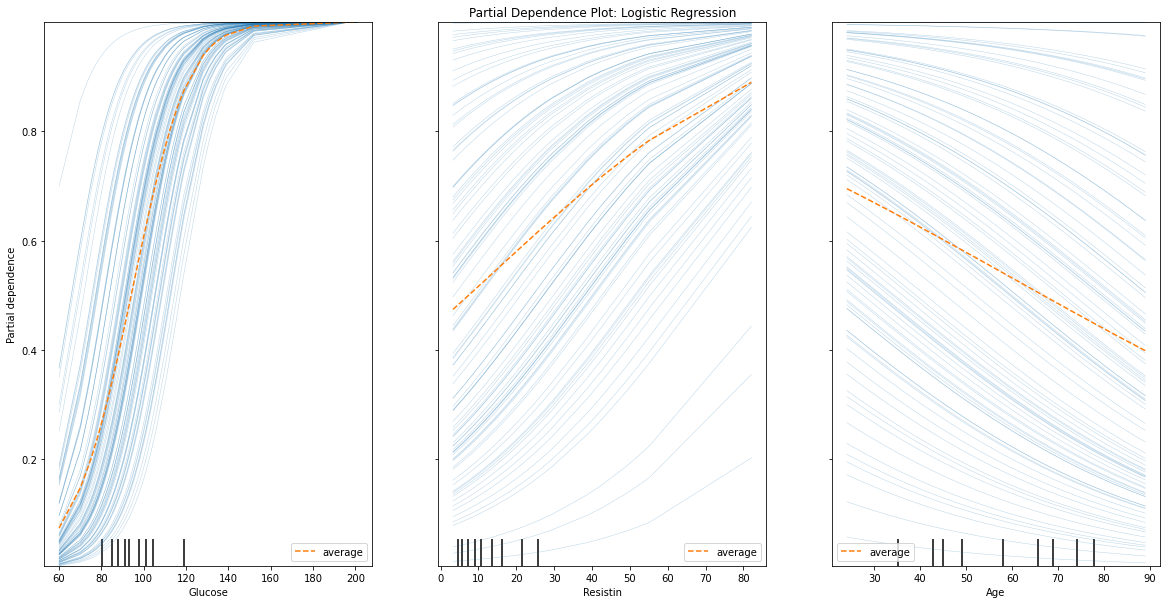

In [147]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Partial Dependence Plot: Logistic Regression")
features = ['Glucose', 'Resistin', 'Age']
fig = PartialDependenceDisplay.from_estimator(lgr_tuned, X, features, ax=ax, kind='both')

In [18]:
rfc_tuned = RandomForestClassifier(bootstrap=True,
                                    max_depth=40, 
                                    max_features=2,
                                    min_samples_leaf=4,
                                    min_samples_split=4,
                                    n_estimators=5)

rfc_tuned = rfc_tuned.fit(X_train, y_train)

Text(0, 0.5, 'Feature Importance Score')

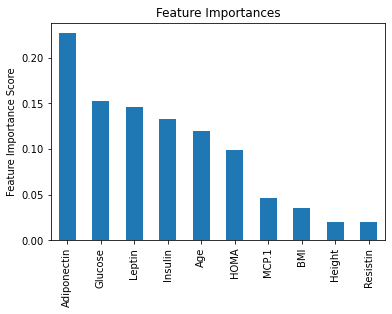

In [20]:
feat_imp = pd.Series(rfc_tuned.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

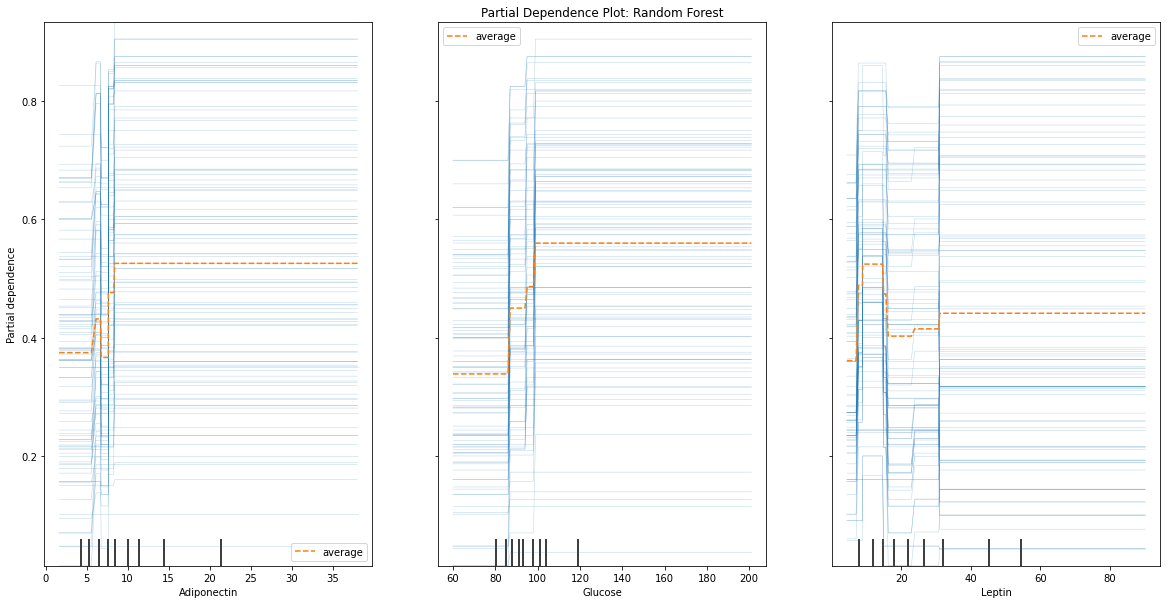

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Partial Dependence Plot: Random Forest")
features = ['Adiponectin', 'Glucose', 'Leptin']
fig = PartialDependenceDisplay.from_estimator(rfc_tuned, X, features, ax=ax, kind='both')

In [64]:
dtc_tuned = DecisionTreeClassifier()
dtc_tuned = dtc_tuned.fit(X_train, y_train)

Text(0, 0.5, 'Feature Importance Score')

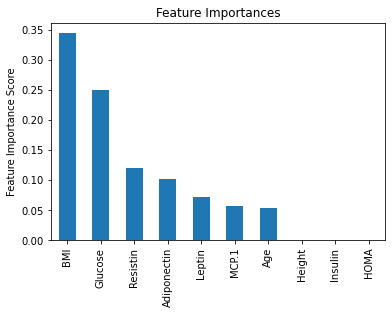

In [65]:
feat_imp = pd.Series(dtc_tuned.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

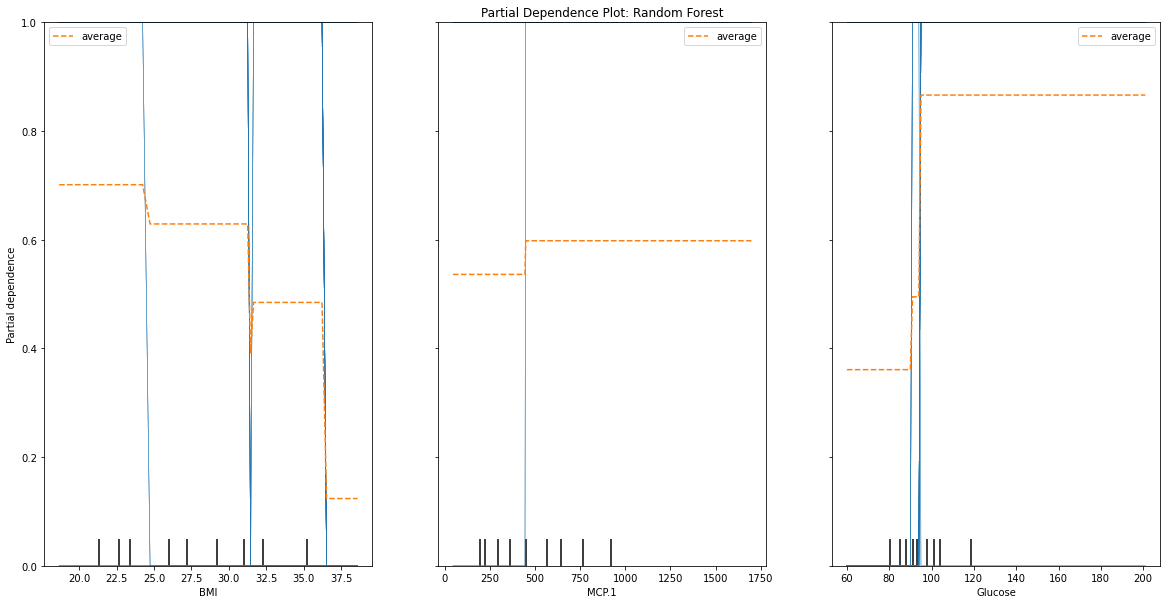

In [66]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Partial Dependence Plot: Random Forest")
features = ['BMI', 'MCP.1', 'Glucose']
fig = PartialDependenceDisplay.from_estimator(dtc_tuned, X, features, ax=ax, kind='both')

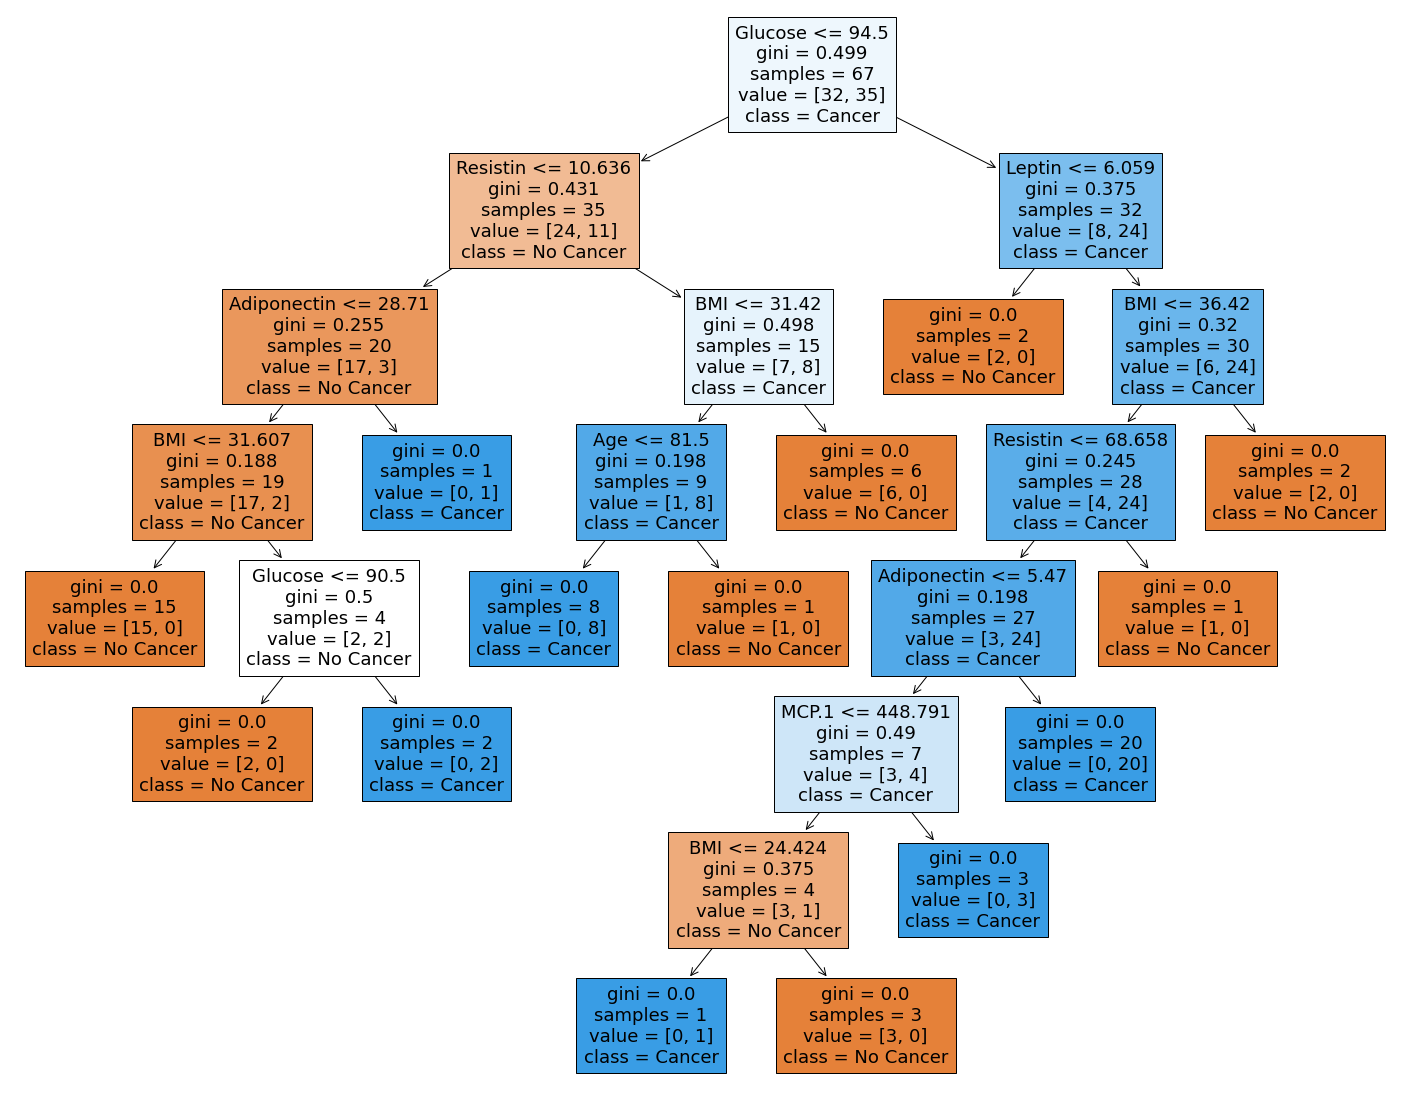

In [67]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc_tuned,
                    feature_names=X.columns,
                    class_names=['No Cancer', 'Cancer'],
                    filled=True)

In [68]:
class BlockingTimeSeriesSplit():
    
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

cv_techniques = [
    ('K-Fold CV', KFold(n_splits=5, random_state=2, shuffle=True)),
    ('Time Series CV', TimeSeriesSplit(n_splits=5)),
    ('Blocking Time Series CV', BlockingTimeSeriesSplit(n_splits=5))
]

for cvs in cv_techniques:

    accu = cross_val_score(dtc_tuned, X_train, y_train, cv=cvs[1], n_jobs=-1, scoring='accuracy')
    accu = [f'{a * 100:.2f}%' for a in accu]
    print(f'{cvs[0]}: {accu}')

K-Fold CV: ['50.00%', '42.86%', '46.15%', '100.00%', '61.54%']
Time Series CV: ['45.45%', '45.45%', '63.64%', '81.82%', '54.55%']
Blocking Time Series CV: ['100.00%', '33.33%', '66.67%', '66.67%', '66.67%']


### Conclusions:

#### Sample size is too small: 

    1. Change in test_size parameter has a large impact on model metric scores.
    
    2. Train-test sample size plots for the models show large variations in mean squared error (mse) values - ideally mse should decrease as training set becomes larger.  
    
    3. Cross validation results are inconsistent.

    4. Variation in data - ICE plots show the individual variations within one feature.

#### Models:

    1. Hyperparameter tuning for ensemble models Random Forest, Gradient Boost and XGBoost can lead to overfitting of the model - difficult to acccurately assess feature importance. 

    2. Logistic regression model shows underfitting to the data 